# Crime example
In this example we use the python GIS stack to look at crime

#### Datasets:
* Crime dataset available from 
    * https://moto.data.socrata.com/dataset/Santa-Clara-County-Sheriff-s-Office/wrmr-tdyp (accessed 7/6/2017) 
* California Neighborhood boundaries, from Zillow: http://www.zillow.com/static/shp/ZillowNeighborhoods-CA.zip (accessed 7/6/2017)  

#### Operations:
* read and write shapefiles using `GIS_utils` (macros around the various GIS packages)
    * `GIS_utils` is available at https://github.com/aleaf/GIS_utils
* plotting shapefile contents using `matplotlib` and `descartes`  
* plotting over basemaps with `cartopy`
* using `shapely` to test for intersections
* using `rtree` to speed up intersections through spatial indexing
* using `pandas` for visualization and general data wrangling

In [1]:
import numpy as np
import pandas as pd
import fiona
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes import PolygonPatch
from rtree import index
from matplotlib.collections import PatchCollection
from GISio import shp2df
from GISops import intersect_rtree, projectdf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
neighborhoods = 'data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp'
# crime dataset from above link trimmed to only 2016-2017 data
crimedata = 'data/Santa_Clara_County_Sheriff_s_Office_2016-2017.csv'

### read in the neighborhood boundaries
* `shp2df` function reads a shapefile, and returns a pandas dataframe of the attribute information, with the geometric information stored in a `geometry` column, as `shapely Point, Linstring, or Polygon` objects

In [3]:
nb_all = shp2df(neighborhoods)
nb_all.head()


reading data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp...
--> building dataframe... (may take a while for large shapefiles)


State       County           City           Name RegionID  \
0    CA    Riverside        Menifee       Sun City     7314   
1    CA  Santa Clara       San Jose         Alviso     8075   
2    CA        Marin     San Rafael  Santa Venetia    20357   
3    CA        Marin     San Rafael      Marinwood    25757   
4    CA  Los Angeles  Santa Clarita        Newhall    26134   

                                            geometry  
0  POLYGON ((-117.1935499999999 33.74306900000005...  
1  POLYGON ((-121.9423569999999 37.46496300000007...  
2  POLYGON ((-122.50308997 38.01594776500008, -12...  
3  POLYGON ((-122.56417078 38.02552641400007, -12...  
4  POLYGON ((-118.5364387599999 34.42379381100029...

In [4]:
sorted(nb_all.City.unique())

['Agoura Hills',
 'Alameda',
 'Albany',
 'Anaheim',
 'Bakersfield',
 'Belmont',
 'Berkeley',
 'Burbank',
 'Calabasas',
 'Campbell',
 'Carlsbad',
 'Cathedral City',
 'Chico',
 'Chula Vista',
 'Citrus Heights',
 'Claremont',
 'Corona',
 'Culver City',
 'Cupertino',
 'Davis',
 'Eastvale',
 'El Monte',
 'Elk Grove',
 'Escondido',
 'Folsom',
 'Foster City',
 'Fremont',
 'Fresno',
 'Fullerton',
 'Glendale',
 'Gustine',
 'Hawthorne',
 'Hayward',
 'Huntington Beach',
 'Irvine',
 'La Verne',
 'Ladera Ranch',
 'Lafayette',
 'Lake Arrowhead',
 'Long Beach',
 'Los Altos',
 'Los Angeles',
 'Malibu',
 'Menifee',
 'Menlo Park',
 'Mill Valley',
 'Milpitas',
 'Monterey',
 'Moreno Valley',
 'Mountain View',
 'Napa',
 'National City',
 'Newport Beach',
 'Novato',
 'Oakland',
 'Oxnard',
 'Pacific Grove',
 'Palm Springs',
 'Palo Alto',
 'Pasadena',
 'Pleasant Hill',
 'Rancho Cordova',
 'Redondo Beach',
 'Redwood City',
 'Richmond',
 'Riverside',
 'Roseville',
 'Sacramento',
 'San Bernardino',
 'San Diego',

In [5]:
# slice the dataframe to only include Madison neighborhoods
#selected = (nb_all.City == 'Palo Alto') | (nb_all.City == 'Menlo Park') | (nb_all.City == 'San Jose')
selected = (nb_all.City == 'San Jose')
nb = nb_all[selected].copy()

# use `shapely` to join the neighborhood polyons into one MultiPolygon, 
# so that we can get a single bounding box for all of them
extent = unary_union(nb.geometry)

In [6]:
x1, y1, x2, y2 = extent.bounds
extent.bounds

(-122.04567199999991, 37.193453, -121.7043589999999, 37.46953800000006)

### make a quick plot of the neighborhoods using `descartes` and `matplotlib.pyplot`
* `PolygonPatch` converts the `shapley Polygon` objects to `matplotlib patches`

(-122.04567199999991, -121.7043589999999)

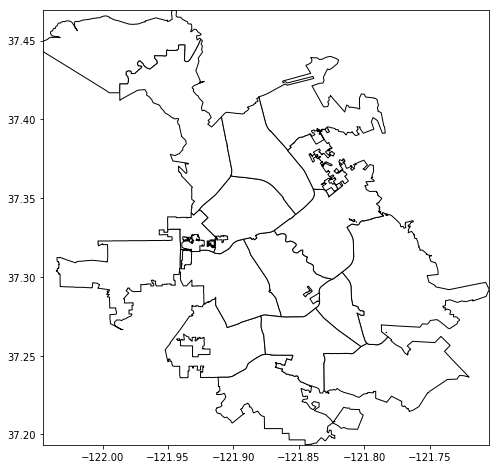

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
collection = PatchCollection([PolygonPatch(p) for p in nb.geometry], facecolor='w', edgecolor='k')
ax.add_collection(collection)
ax.set_ylim(y1, y2)
ax.set_xlim(x1, x2)

### Plot using `cartopy` to add basemap
similar to this example:
http://scitools.org.uk/cartopy/docs/v0.15/examples/eyja_volcano.html

except using **Google tiles** so we can see streets, etc. To see other options, type
`cimgt.` and hit tab

unfortunately many of the map tile options may produce an error that is ultimately related
to an SSL certificate issue.  
The following code provides a work-around:

In [8]:
import ssl
if hasattr(ssl, '_create_unverified_context'):
    ssl._create_default_https_context = ssl._create_unverified_context

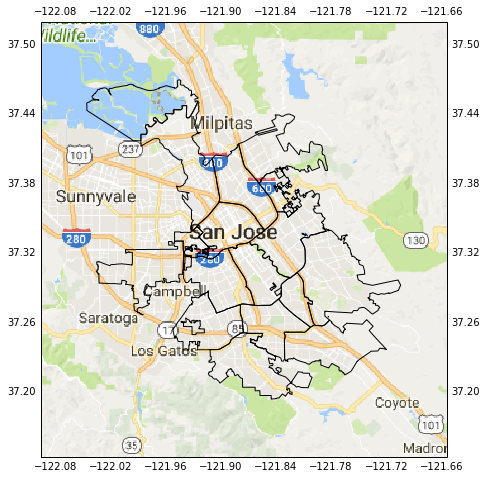

In [9]:
#tiles = cimgt.StamenTerrain() # Stamen tiles did not produce an SSL error
tiles = cimgt.GoogleTiles()

# Create a GeoAxes in the tile's projection.
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=tiles.crs)

# Limit the extent of the map to a small longitude/latitude range.
pad = .05
ax.set_extent([x1-pad, x2+pad, y1-pad, y2+pad])

# Add the Stamen data at zoom level 8.
ax.add_image(tiles, 10)

collection = PatchCollection([PolygonPatch(p) for p in nb.geometry], 
                             facecolor='none', edgecolor='k', lw=1, zorder=10,
                             transform=ccrs.PlateCarree())
ax.add_collection(collection)
    
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False

### Read indicident data into `pandas DataFrame`

Note: `pandas.read_csv` might take awhile with large files (such as the full crime dataset); and there might be other issues. We can speed up `read_csv` by specifying the datatype for each column a-priori. In this case, it's easiest to load all of the columns as strings, and convert numeric dtypes later.  

Get the column names by opening the file with python first;  
Make a dictionary of the column names

In [10]:
with open(crimedata) as input:
    lines = input.readlines()[:2]
    lines = [l.split(',') for l in lines]
d = dict(zip(*lines))
d

{'address_1': 'W DUNNE AV',
 'address_2': '',
 'case_number': 'S161700025',
 'city': 'SANTA CLARA COUNTY',
 'clearance_type': '',
 'country': '',
 'created_at': '06/19/2016 06:21:04 AM',
 'day_of_week': 'Saturday',
 'geometry\n': 'POINT (-121.649027382508 37.1252776960244)\n',
 'hour_of_day': '1',
 'incident_datetime': '06/18/2016 01:50:46 AM',
 'incident_description': 'Call Type: 1095 <br>Description: PEDESTRIAN STOP<br>Final Disposition: N',
 'incident_id': '762597294',
 'incident_type_primary': 'Pedestrian Stop',
 'latitude': '37.1252776960244',
 'location': 'POINT (-121.649027382508 37.1252776960244)',
 'longitude': '-121.649027382508',
 'parent_incident_type': 'Proactive Policing',
 'state': 'CA',
 'updated_at': '06/25/2016 08:31:26 AM',
 'zip': ''}

### read the csv file into pandas
switch the values of the above dictionary to the string dtype

In [11]:
df = pd.read_csv(crimedata, dtype={k:str for k in d.keys()})
df.index = pd.to_datetime(df.incident_datetime)
df.head()

incident_datetime incident_id case_number  \
incident_datetime                                                  
2016-06-18 01:50:46  2016-06-18 01:50:46   762597294  S161700025   
2016-06-18 01:55:27  2016-06-18 01:55:27   762597293  S161700026   
2016-06-18 02:07:30  2016-06-18 02:07:30   762597292  S161700027   
2016-06-18 02:08:13  2016-06-18 02:08:13   762597291  S161700028   
2016-06-18 02:11:00  2016-06-18 02:11:00   762597290  S161700029   

                        incident_datetime.1 incident_type_primary  \
incident_datetime                                                   
2016-06-18 01:50:46  06/18/2016 01:50:46 AM       Pedestrian Stop   
2016-06-18 01:55:27  06/18/2016 01:55:27 AM    Community Policing   
2016-06-18 02:07:30  06/18/2016 02:07:30 AM               Traffic   
2016-06-18 02:08:13  06/18/2016 02:08:13 AM                 Other   
2016-06-18 02:11:00  06/18/2016 02:11:00 AM       Pedestrian Stop   

                                                  incident_description  \
incident_datetime                                                        
2016-06-18 01:50:46  Call Type: 1095 <br>Description: PEDESTRIAN ST...   
2016-06-18 01:55:27  Call Type: PATCK <br>Description: PATROL CHECK...   
2016-06-18 02:07:30  Call Type: 23152 <br>Description: MISDEMEANOR ...   
2016-06-18 02:08:13  Call Type: 1154 <br>Description: SUSPICIOUS VE...   
2016-06-18 02:11:00  Call Type: 1095 <br>Description: PEDESTRIAN ST...   

                    clearance_type                 address_1 address_2  \
incident_datetime                                                        
2016-06-18 01:50:46            NaN                W DUNNE AV       NaN   
2016-06-18 01:55:27            NaN                BURNETT AV       NaN   
2016-06-18 02:07:30            NaN            EL CAMINO REAL       NaN   
2016-06-18 02:08:13            NaN  14000 Block PAGE MILL RD       NaN   
2016-06-18 02:11:00            NaN        STEVENS CREEK BLVD       NaN   

                                   city  \
incident_datetime                         
2016-06-18 01:50:46  SANTA CLARA COUNTY   
2016-06-18 01:55:27  SANTA CLARA COUNTY   
2016-06-18 02:07:30  SANTA CLARA COUNTY   
2016-06-18 02:08:13  SANTA CLARA COUNTY   
2016-06-18 02:11:00  SANTA CLARA COUNTY   

                                        ...                     country  \
incident_datetime                       ...                               
2016-06-18 01:50:46                     ...                         NaN   
2016-06-18 01:55:27                     ...                         NaN   
2016-06-18 02:07:30                     ...                         NaN   
2016-06-18 02:08:13                     ...                         NaN   
2016-06-18 02:11:00                     ...                         NaN   

                             latitude          longitude  \
incident_datetime                                          
2016-06-18 01:50:46  37.1252776960244  -121.649027382508   
2016-06-18 01:55:27  37.1631037628581  -121.661207382967   
2016-06-18 02:07:30  37.4324646764186  -122.153536709011   
2016-06-18 02:08:13  37.3849293292592  -122.164360157798   
2016-06-18 02:11:00   37.322954659466  -122.022169203125   

                                 created_at              updated_at  \
incident_datetime                                                     
2016-06-18 01:50:46  06/19/2016 06:21:04 AM  06/25/2016 08:31:26 AM   
2016-06-18 01:55:27  06/19/2016 06:21:04 AM  06/25/2016 08:31:26 AM   
2016-06-18 02:07:30  06/19/2016 06:21:04 AM  06/25/2016 08:31:26 AM   
2016-06-18 02:08:13  06/19/2016 06:21:04 AM  06/25/2016 08:31:27 AM   
2016-06-18 02:11:00  06/19/2016 06:21:04 AM  06/25/2016 08:31:27 AM   

                                                       location hour_of_day  \
incident_datetime                                                             
2016-06-18 01:50:46  POINT (-121.649027382508 37.1252776960244)           1   
2016-06-18 01:55:27  POINT (-121.6612073

### convert the lat/lons to floats; make another column of `shapely Points`

In [12]:
df['longitude'] = df.longitude.astype(float)
df['latitude'] = df.latitude.astype(float)
df['geometry'] = [Point(*xy) for xy in zip(df.longitude, df.latitude)]

### get the bounds of the dataset; toss out any points that are unreasonable

In [13]:
def bounds(df):
    return df.longitude.min(), df.latitude.min(), \
           df.longitude.max(), df.latitude.max()
xmin, ymin, xmax, ymax = bounds(df)
xmin, ymin, xmax, ymax

(-122.2363548, 36.8415721, -121.21423648053501, 37.532565099999999)

In [14]:
len(df)

163203

In [15]:
valid = (df.longitude < -120) & (df.longitude > -123) & (df.latitude > 36) & (df.latitude < 37.6)
df = df.loc[valid].copy()
len(df)

163203

In [16]:
xmin, ymin, xmax, ymax = bounds(df)
xmin, ymin, xmax, ymax

(-122.2363548, 36.8415721, -121.21423648053501, 37.532565099999999)

### Count number of incidents by date, and plot

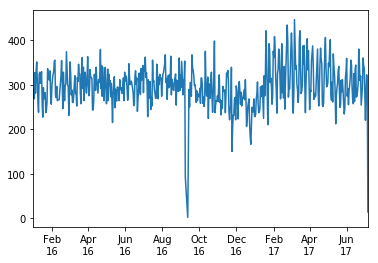

In [17]:
import matplotlib.dates as dates
ax = df.groupby(df.index.date).count().incident_id.plot()
ax.xaxis.set_major_formatter(dates.DateFormatter('%b\n%y'))


In [18]:
df.columns

Index(['incident_datetime', 'incident_id', 'case_number',
       'incident_datetime.1', 'incident_type_primary', 'incident_description',
       'clearance_type', 'address_1', 'address_2', 'city', 'state', 'zip',
       'country', 'latitude', 'longitude', 'created_at', 'updated_at',
       'location', 'hour_of_day', 'day_of_week', 'parent_incident_type',
       'geometry'],
      dtype='object')

### list the all of the incident types in that dataset

In [19]:
df.incident_type_primary.unique()

array(['Pedestrian Stop', 'Community Policing', 'Traffic', 'Other',
       'Vehicle Stop', 'Alarm', 'Disorder', 'Missing Person', 'Drugs',
       'Theft', 'Breaking & Entering', 'Family Offense',
       'Theft from Vehicle', 'Assault', 'Property Crime', 'Robbery',
       'Death', 'Theft of Vehicle', 'Weapons Offense',
       'Other Sexual Offense', 'Vehicle Recovery',
       'Assault with Deadly Weapon', 'Liquor', 'Arson', 'Kidnapping',
       'Sexual Assault', 'Homicide'], dtype=object)

### Add the incidents to the map with neighborhoods
* overplotting of points in dense areas prevents us from seeing how much crime they actually have  
* the [datashader](https://github.com/bokeh/datashader) package can be used to visualize dense point data

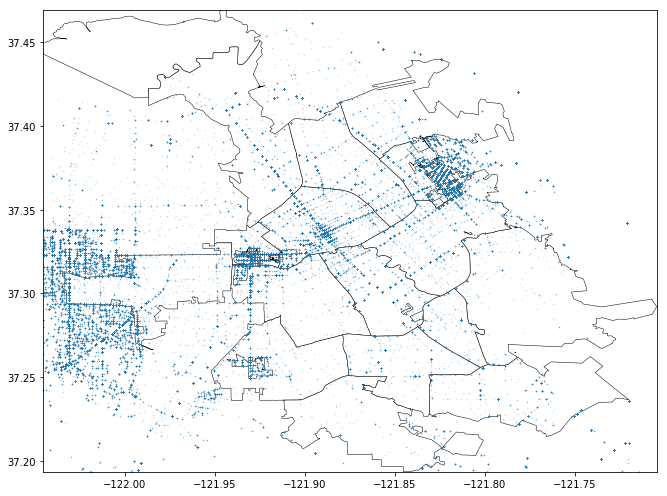

In [20]:
fig, ax = plt.subplots(figsize=(11, 8.5))
collection = PatchCollection([PolygonPatch(p) for p in nb.geometry], facecolor='w', lw=.5, edgecolor='k')
ax.add_collection(collection)

ax.set_ylim(y1, y2)
ax.set_xlim(x1, x2)
ax.scatter(df.longitude, df.latitude, s=.2, alpha=.2)

#### Get rid of invalid points first to minimize issues in the spatial join
* invalid points can cause ```rtree``` to crash

In [21]:
# drop indicents without lat/lon values
df.dropna(axis=0, subset=['longitude', 'latitude'], inplace=True)

# make shapley point objects out of the lat, lon values
df['geometry'] = [Point(*xy) for xy in zip(df.longitude.values, df.latitude.values)]

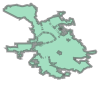

In [22]:
# drop any points that aren't within the city (using the polygon we defined earlier)
# use the bounds because the union of the neighborhood polygons is too complex
# (meaning it will take shapely a while to determine intersections)
extent

In [23]:
extent.bounds

(-122.04567199999991, 37.193453, -121.7043589999999, 37.46953800000006)

In [24]:
from shapely.geometry import box # makes a polygon out of bounding coordinates
bounds = box(*extent.bounds)
within = [g.within(bounds) for g in df.geometry] # test whether each incident is within the bounding box
print(within[0:100])

[False, False, False, False, True, False, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, False, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, False, False, False]


In [25]:
df = df[within].copy() # make a copy so that we are no longer working with the old DataFrame

In [26]:
len(df), len(nb), len(df)*len(nb)

(122636, 17, 2084812)

### Aggregate the number of incidents by neighborhood
* this requires each point to be tested for each neighborhood (2 million operations if we have 122,636 incidents and 17 neighborhoods)
* the `rtree` package can speed up this process via spatial indexing  
https://en.wikipedia.org/wiki/R-tree
* use the ```intersect_rtree``` macro for convenience
* `intersect_rtree` takes two lists of shapely geometry objects, and
    * reduces objects in the first list to bounding boxes, and builds an rtree spatial index of them
    * for each object in list 2, uses rtree to find the bounding boxes in list 1 that intersect the bounding boxe of the object
        * from the initial list of bounding box intersections, uses shapely to test the actual geometric features for intersection with each other

In [27]:
nb.geometry.values

array([<shapely.geometry.polygon.Polygon object at 0x11d230eb8>,
       <shapely.geometry.multipolygon.MultiPolygon object at 0x11d2f25f8>], dtype=object)

In [28]:
inds = intersect_rtree(df.geometry.tolist(), nb.geometry.tolist())


Building spatial index...
finished in 8.82s

Intersecting 17 features...
17
finished in 53.95s



#### ```intersect_rtree``` returns a lists of lists  
* (length equal to the number of neighborhood polygons), 
* each inner list containing the indicies of points within that neighborhood

In [29]:
print(inds[0])

[88369, 88402, 88836, 90161, 90397, 90810, 91587, 91864, 92066, 92124, 92351, 92896, 94739, 95508, 95765, 96175, 96280, 96311, 96582, 96920, 97159, 98048, 98511, 98939, 99005, 100471, 100603, 100777, 101055, 101914, 45207, 102378, 46137, 46583, 46818, 47686, 47751, 47927, 48484, 48607, 48712, 56677, 56877, 57174, 57288, 57289, 57859, 58146, 59748, 59935, 60402, 60961, 61513, 61779, 61886, 62310, 62832, 62850, 63138, 64421, 65401, 68493, 68712, 68933, 69099, 70088, 70331, 70651, 70819, 71094, 71184, 71298, 71702, 71735, 72165, 72251, 72650, 72651, 72829, 73246, 73944, 74179, 74428, 74636, 75906, 76283, 76454, 76582, 76610, 76611, 77555, 29650, 77905, 30007, 30669, 30701, 30707, 30853, 30933, 31274, 29779, 3554, 38593, 39243, 39282, 39443, 39528, 39642, 40720, 40824, 41199, 41618, 42366, 42598, 42910, 43481, 43541, 44082, 44260, 44263, 44637, 45465, 64615, 66083, 66802, 66930, 66991, 67484, 67610, 68164, 68165, 68352, 78173, 78453, 78614, 79113, 79337, 79503, 79603, 79973, 80300, 80313, 

### count the number of incidents in each neighborhood  
* assign this to a new column in the neighborhoods dataframe

In [30]:
nb['n_incidents'] = [len(i) for i in inds]
nb

State       County      City                      Name RegionID  \
1       CA  Santa Clara  San Jose                    Alviso     8075   
22      CA  Santa Clara  San Jose             Cambrian Park   114074   
68      CA  Santa Clara  San Jose                 Berryessa   113736   
74      CA  Santa Clara  San Jose                 Evergreen   115003   
213     CA  Santa Clara  San Jose               Willow Glen   118987   
636     CA  Santa Clara  San Jose               Fairgrounds   273674   
688     CA  Santa Clara  San Jose            North San Jose   274741   
742     CA  Santa Clara  San Jose            Almaden Valley   272756   
746     CA  Santa Clara  San Jose               Rose Garden   275243   
810     CA  Santa Clara  San Jose    Edenvale - Seven Trees   273594   
879     CA  Santa Clara  San Jose            Blossom Valley   276215   
881     CA  Santa Clara  San Jose  Alum Rock-East Foothills   272760   
937     CA  Santa Clara  San Jose                  Downtown   273480   
942     CA  Santa Clara  San Jose              North Valley   274756   
947     CA  Santa Clara  San Jose             East San Jose   273565   
998     CA  Santa Clara  San Jose              Santa Teresa   275306   
1105    CA  Santa Clara  San Jose             West San Jose   276652   

                                               geometry  n_incidents  
1     POLYGON ((-121.9423569999999 37.46496300000007...          324  
22    POLYGON ((-121.878978755 37.27530488000008, -1...         1242  
68    POLYGON ((-121.8202519999999 37.43812700000007...         1373  
74    (POLYGON ((-121.7826669999999 37.2649340000000...          513  
213   POLYGON ((-121.8874382369999 37.31590445900008...         4255  
636   POLYGON ((-121.8666420729999 37.32674963100004...         4090  
688   POLYGON ((-121.9262689999999 37.43683900000008...         2201  
742   (POLYGON ((-121.823902 37.20757, -121.82372407...          188  
746   POLYGON ((-121.9246463649999 37.34204677500009...         2316  
810   POLYGON ((-121.8167705539999 37.30293083300006...          951  
879   POLYGON ((-121.8325538629999 37.27554512100005...         1830  
881   (POLYGON ((-121.8348639999999 37.3753390000000...         3180  
937   POLYGON ((-121.8548126224163 37.34227180535527...        10835  
942   POLYGON ((-121.8774566643825 37.40456199673176...         2244  
947   POLYGON ((-121.8154314229999 37.37412807800007...         4159  
998   POLYGON ((-121.7412054959999 37.26219843300004...         1640  
1105  (POLYGON ((-121.9851329659999 37.2665866650000...         7610

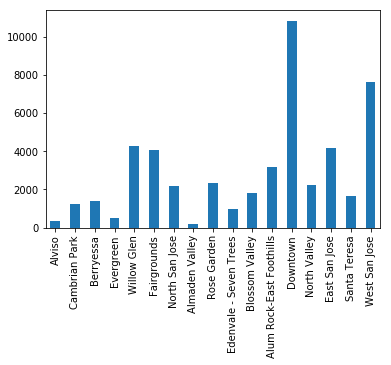

In [31]:
ax = nb.n_incidents.plot(kind='bar')
ticks = ax.set_xticklabels(nb.Name)

### plot number of incidents by neighborhood

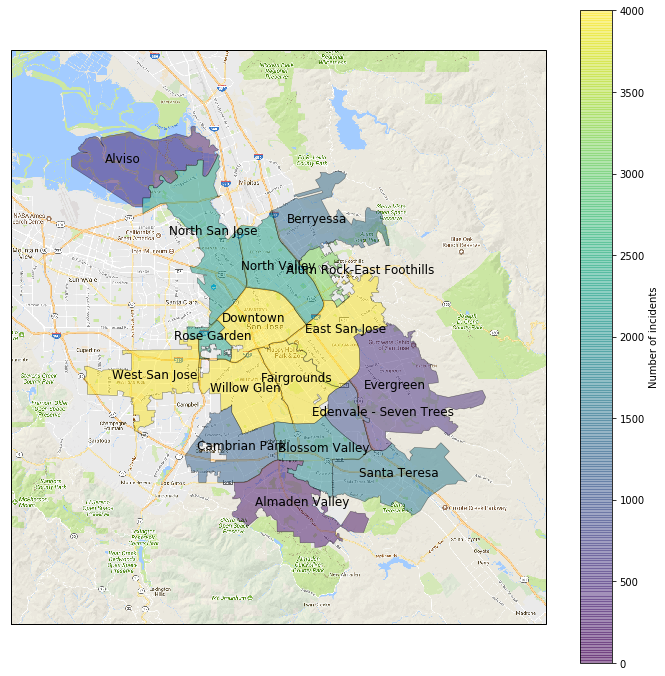

In [32]:
#fig, ax = plt.subplots(figsize=(11, 8.5))
# Create a GeoAxes in the tile's projection.
tiles = cimgt.GoogleTiles(style='street')

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=tiles.crs)

# Limit the extent of the map to a small longitude/latitude range.
pad = .05
ax.set_extent([x1-pad, x2+pad, y1-pad, y2+pad])

# Add the Stamen data at zoom level 8.
ax.add_image(tiles, 12)

# make a patch collection of the neighborhood polygons
collection = PatchCollection([PolygonPatch(p) for p in nb.geometry], 
                             facecolor='w', alpha=.5, edgecolor='k', lw=0.5,
                             transform=ccrs.PlateCarree())

# set an array of color values for the neighborhood patches
collection.set_array(nb.n_incidents.values)

# set the color limit based on the histogram above
collection.set_clim(0, 4000)

# add the collection to the plot
ax.add_collection(collection)
#ax.set_ylim(y1, y2)
#ax.set_xlim(x1, x2)
cb = fig.colorbar(collection, label='Number of incidents')

# label the neighborhoods
centers = [g.centroid for g in nb.geometry]
for i in range(len(centers)):
    label = nb.Name.values[i]
    offset = -.03, 0 #-.03, .01
    x, y = np.squeeze(centers[i].xy) + offset
    ax.text(x, y, label, fontsize=12, transform=ccrs.PlateCarree())


## Finish the spatial join
* add the neighborhoods to the crime dataframe to allow for additional analyses

In [33]:
nb.head()

State       County      City           Name RegionID  \
1      CA  Santa Clara  San Jose         Alviso     8075   
22     CA  Santa Clara  San Jose  Cambrian Park   114074   
68     CA  Santa Clara  San Jose      Berryessa   113736   
74     CA  Santa Clara  San Jose      Evergreen   115003   
213    CA  Santa Clara  San Jose    Willow Glen   118987   

                                              geometry  n_incidents  
1    POLYGON ((-121.9423569999999 37.46496300000007...          324  
22   POLYGON ((-121.878978755 37.27530488000008, -1...         1242  
68   POLYGON ((-121.8202519999999 37.43812700000007...         1373  
74   (POLYGON ((-121.7826669999999 37.2649340000000...          513  
213  POLYGON ((-121.8874382369999 37.31590445900008...         4255

In [34]:
# make an empty array of strings the same length as the dataframe
# the dtype has to be an object or large enough string to accommodate the long neighborhood names
neighborhoods = np.array([''] * len(df), dtype=np.object)

# now iterate through the neighborhoods dataframe and assign the neighborhood name to the indices we got from rtree
for i, n in enumerate(nb.Name):
    neighborhoods[inds[i]] = n
neighborhoods

array(['', 'Berryessa', 'Rose Garden', ..., '', '', ''], dtype=object)

In [35]:
# assign this to a new column in the incidents dataframe
df['neighborhood'] = neighborhoods
df.head()

incident_datetime incident_id case_number  \
incident_datetime                                                  
2016-06-18 02:11:00  2016-06-18 02:11:00   762597290  S161700029   
2016-06-18 02:25:33  2016-06-18 02:25:33   762597288  S161700031   
2016-06-18 02:29:58  2016-06-18 02:29:58   762597286  S161700033   
2016-04-22 01:30:17  2016-04-22 01:30:17   757679968  S161130019   
2016-04-22 01:32:22  2016-04-22 01:32:22   757679967  S161130020   

                        incident_datetime.1 incident_type_primary  \
incident_datetime                                                   
2016-06-18 02:11:00  06/18/2016 02:11:00 AM       Pedestrian Stop   
2016-06-18 02:25:33  06/18/2016 02:25:33 AM    Community Policing   
2016-06-18 02:29:58  06/18/2016 02:29:58 AM          Vehicle Stop   
2016-04-22 01:30:17  04/22/2016 01:30:17 AM          Vehicle Stop   
2016-04-22 01:32:22  04/22/2016 01:32:22 AM       Pedestrian Stop   

                                                  incident_description  \
incident_datetime                                                        
2016-06-18 02:11:00  Call Type: 1095 <br>Description: PEDESTRIAN ST...   
2016-06-18 02:25:33  Call Type: WELCK <br>Description: WELFARE CHEC...   
2016-06-18 02:29:58  Call Type: 1195 <br>Description: VEHICLE STOP<...   
2016-04-22 01:30:17  Call Type: 1195 <br>Description: VEHICLE STOP<...   
2016-04-22 01:32:22  Call Type: 1095 <br>Description: PEDESTRIAN ST...   

                    clearance_type                address_1 address_2  \
incident_datetime                                                       
2016-06-18 02:11:00            NaN       STEVENS CREEK BLVD       NaN   
2016-06-18 02:25:33            NaN  1200 Block N CAPITOL AV       NaN   
2016-06-18 02:29:58            NaN                 SCOTT ST       NaN   
2016-04-22 01:30:17            NaN                  ROSE AV       NaN   
2016-04-22 01:32:22            NaN                   FY 101       NaN   

                                   city      ...        latitude   longitude  \
incident_datetime                            ...                               
2016-06-18 02:11:00  SANTA CLARA COUNTY      ...       37.322955 -122.022169   
2016-06-18 02:25:33  SANTA CLARA COUNTY      ...       37.389431 -121.861869   
2016-06-18 02:29:58  SANTA CLARA COUNTY      ...       37.319816 -121.920373   
2016-04-22 01:30:17  SANTA CLARA COUNTY      ...       37.364703 -121.825767   
2016-04-22 01:32:22  SANTA CLARA COUNTY      ...       37.353896 -121.864902   

                                 created_at              updated_at  \
incident_datetime                                                     
2016-06-18 02:11:00  06/19/2016 06:21:04 AM  06/25/2016 08:31:27 AM   
2016-06-18 02:25:33  06/19/2016 06:21:04 AM  06/25/2016 08:31:27 AM   
2016-06-18 02:29:58  06/19/2016 06:21:04 AM  06/25/2016 08:31:28 AM   
2016-04-22 01:30:17  04/23/2016 06:11:27 AM  04/29/2016 08:33:03 AM   
2016-04-22 01:32:22  04/23/2016 06:11:27 AM  04/29/2016 08:33:03 AM   

                                                       location hour_of_day  \
incident_datetime                                                             
2016-06-18 02:11:00   POINT (-122.022169203125 37.322954659466)           2   
2016-06-18 02:25:33  POINT (-121.861868571156 37.3894311885983)           2   
2016-06-18 02:29:58  POINT (-121.920373017757 37.3198159498632)           2   
2016-04-22 01:30:17  POINT (-121.825766681502 37.3647033419589)           1   
2016-04-22 01:32:22  POINT (-121.864902358948 37.3538959568106)           1   

                    day_of_week parent_incident_type  \
incident_datetime                                      
2016-06-18 02:11:00    Saturday   Proactive Policing   
2016-06-18 02:25:33    Saturday   Proactive Policing   
2016-06-18 02:29:58    Saturday   Proactive Policing   
2016-04-22 01:30:17      Friday   Proactive Policing   
2016-04-22 01:32:22      Friday   Proactive Policing   

                         

### Find out how neighborhoods compare for car break-ins

In [36]:
df.loc[df.incident_type_primary == 'Theft from Vehicle'].groupby('neighborhood').count().incident_id

neighborhood
                            583
Almaden Valley                3
Alum Rock-East Foothills      8
Alviso                        4
Berryessa                     7
Blossom Valley               14
Cambrian Park                 7
Downtown                      6
East San Jose                 3
Edenvale - Seven Trees        2
Evergreen                     2
Fairgrounds                  34
North San Jose                3
North Valley                  1
Rose Garden                   6
Santa Teresa                 16
West San Jose                27
Willow Glen                  15
Name: incident_id, dtype: int64

### What are the most common crimes in Downtown vs. West San Jose?

In [37]:
df.loc[df.neighborhood == 'Downtown'].groupby('incident_type_primary').count().incident_id.sort_values(ascending=False)

incident_type_primary
Other                         2547
Pedestrian Stop               2065
Vehicle Stop                  1994
Community Policing             978
Disorder                       798
Alarm                          646
Assault                        473
Traffic                        318
Property Crime                 240
Missing Person                 151
Vehicle Recovery               112
Theft                           98
Other Sexual Offense            92
Drugs                           82
Weapons Offense                 47
Death                           44
Sexual Assault                  42
Robbery                         30
Theft of Vehicle                24
Assault with Deadly Weapon      23
Family Offense                  15
Theft from Vehicle               6
Breaking & Entering              6
Homicide                         2
Kidnapping                       1
Arson                            1
Name: incident_id, dtype: int64

In [38]:
df.loc[df.neighborhood == 'West San Jose'].groupby('incident_type_primary').count().incident_id.sort_values(ascending=False)

incident_type_primary
Vehicle Stop                  4731
Other                          603
Pedestrian Stop                521
Community Policing             410
Traffic                        408
Alarm                          272
Theft                          200
Disorder                       176
Property Crime                  73
Missing Person                  32
Breaking & Entering             31
Vehicle Recovery                27
Theft from Vehicle              27
Assault                         27
Theft of Vehicle                16
Death                           14
Other Sexual Offense            11
Robbery                          9
Weapons Offense                  8
Family Offense                   7
Drugs                            5
Assault with Deadly Weapon       1
Kidnapping                       1
Name: incident_id, dtype: int64